### 📘 Lesson 11: Hydropower Plant Modelling

<div style="display: flex; align-items: center; justify-content: space-between;">
  <div>
    <h3>Course presenters</h3>
    <ul>
      <li><strong>Priyesh Gosai</strong> - Energy Systems Modeler and Training Coordinator</li>
      <li><strong>Dr. Graeme Chown</strong> - Chown and Associates</li>
    </ul>
  </div>
  <div>
    <a href="https://openenergytransition.org/index.html">
      <img src="https://openenergytransition.org/assets/img/oet-logo-red-n-subtitle.png" height="60" alt="OET">
    </a>
  </div>
</div>

#### 🎯 Learning Objectives  



* Run a demonstration model using real data. 
* Solve the Day ahead and intra day model. 
* Analyse the results.


**Setup Environment**

In [ ]:
# @title "Mount Google Drive and Set Working Directory"

from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set FOLDER and change to the working directory in one step
FOLDER = 'ich-modeling-2025'
os.chdir(f'/content/drive/MyDrive/{FOLDER}')

# Confirm the current working directory
print("Current working directory:", os.getcwd())

In [ ]:
# @title Install latest version of PyPSA with Excel support

import os
from IPython.display import clear_output

# Install required packages
os.system("pip install -q pypsa")
os.system("pip install -q 'pypsa[excel]'")
os.system("pip install -q folium mapclassify")

# Clear the output after installation
clear_output()

# Notify the user
print("✅ All required packages have been installed.\n"
      "💡 To comment this cell, select all the text and press `Ctrl + /`.")

### 🧩 Theory

**💧 Representing Hydropower in PyPSA**

In PyPSA, hydropower plants are typically modeled using the `storage_unit` component.  
While the electrical network operates in units of **MW** (power) or **MWh** (energy), hydropower inputs are often based on **river flows**, which are measured in **million cubic meters per hour** ($\text{Mm}^3/\text{h}$).

To bridge this unit difference, we use a **conversion factor** derived from the fundamental hydropower equation:


$$P = \eta \cdot \rho \cdot g \cdot Q \cdot H$$

Where:
- $P$ = Power output in watts (W)  
- $\eta$ = Turbine-generator efficiency (dimensionless)  
- $\rho$ = Density of water (≈ 1000 kg/m³)  
- $g$ = Gravitational acceleration (≈ 9.81 m/s²)  
- $Q$ = Flow rate (m³/s)  
- $H$ = Net head (m)

By applying this formula, we can **convert flow rates** from $\text{Mm}^3/\text{h}$ into **megawatts (MW)**, which allows the hydropower plant to integrate seamlessly into the electricity network model. This conversion factor becomes the **efficiency** term in the `storage_unit` definition within PyPSA.

![TEPSCO_EDL_PyPSA Diagrams V0-Page-2.drawio.png](<attachment:TEPSCO_EDL_PyPSA Diagrams V0-Page-2.drawio.png>)
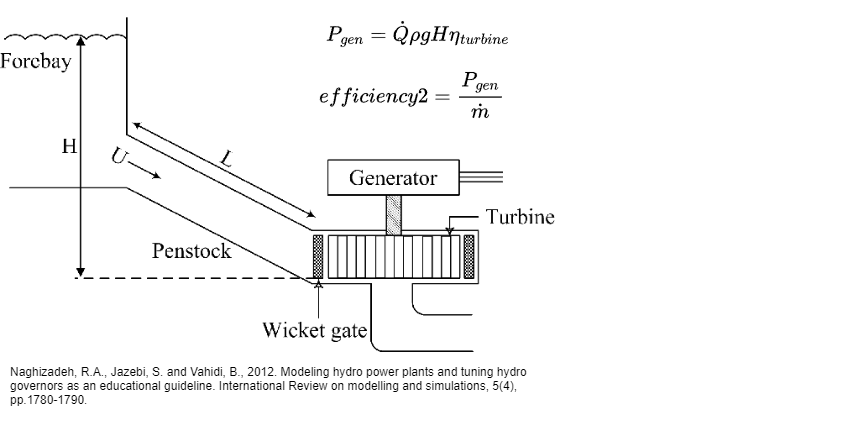

![TEPSCO_EDL_PyPSA Diagrams V0-Full Network.drawio.png](<attachment:TEPSCO_EDL_PyPSA Diagrams V0-Full Network.drawio.png>)
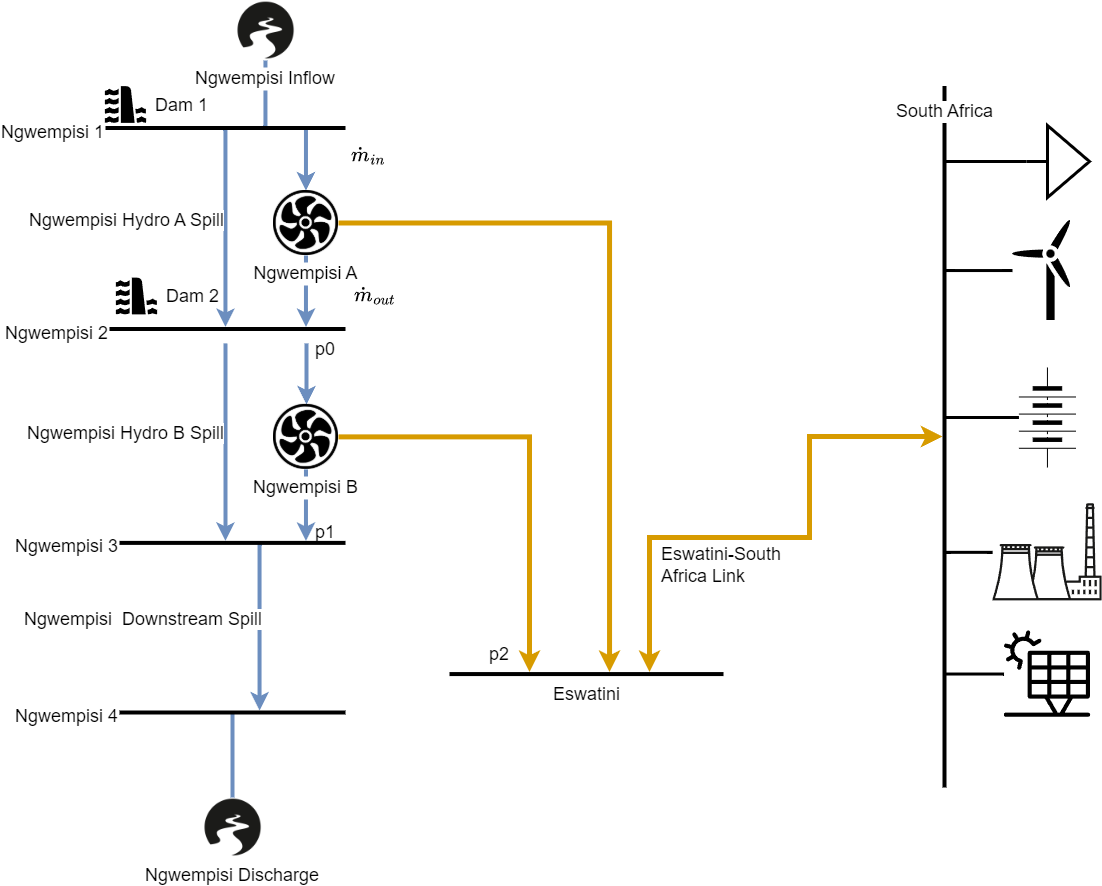

In [ ]:
import pypsa
import pandas as pd
import numpy as np


In [ ]:
input_file_name = 'data/Lesson11_ZA_Hydropower.xlsx'

In [ ]:
network = pypsa.Network(input_file_name )


In [ ]:
network.optimize(solver_name='highs')

In [ ]:
network.generators_t.p.plot(kind ="area")

In [ ]:
hydropower_links = (network.links_t.p2 * -1).sum() > 1
hydropower_generators = hydropower_links[hydropower_links].index
hydropower_generators

storage_generators = network.storage_units_t.p.columns

df_generation = network.generators_t.p[network.generators[network.generators.carrier != "water"].index]
df_generation[hydropower_generators] = (network.links_t.p2 * -1)[hydropower_generators]
df_generation[storage_generators] = network.storage_units_t.p[storage_generators] 



In [ ]:
df_generation[["Loadshedding","Sync Condenser"]].describe()

In [ ]:
import plotly.express as px

# Create a copy and add a new "Load" column from the sum of loads
df_load_duration_curve = df_generation.copy()
df_load_duration_curve["Load"] = network.loads_t.p_set.sum(axis=1)



# Sort the dataframe in descending order of Load and then reverse it so that the x-axis (index) is increasing
df_load_duration_curve = df_load_duration_curve.sort_values(by="Load", ascending=False).iloc[::-1]

# df_load_duration_curve.reset_index()
# df_load_duration_curve.drop(columns = 'snapshots')


In [ ]:
df_load_duration_curve = df_load_duration_curve.reset_index(drop=True)

In [ ]:
df_load = df_load_duration_curve["Load"].copy()

In [ ]:
df_load_duration_curve = df_load_duration_curve.drop(columns="Load")

In [ ]:
df_load_duration_curve.plot(kind = "area")


In [ ]:
df_load.plot()

In [ ]:

df_load_duration_curve = df_generation.copy()
df_load_duration_curve["Load"] = network.loads_t.p_set.sum(axis= 1)#["SA Load"]


In [ ]:
df_generation.plot(kind = 'area')

In [ ]:
network.links["carrier"]

```


```

In [ ]:
network.stores_t.e.plot()


###
---